In [2]:
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(plyranges))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(ggrepel))

barcode_reads_cutoff <- 10
insert_reads_cutoff <- 300
barcodes_cutoff <- 5

In [3]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(size=0.2),
        axis.line.y=element_line(size=0.2),
        axis.ticks.y =  element_line(size=0.2),
        axis.ticks.x = element_line(size=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [4]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

## Plot CSCs of dicodon library vs endogenous fragments library in WT


In [5]:
insert_annotations_1 = read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv") %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    mutate(aa = as.character(translate(DNAStringSet(insert), no.init.codon = T)))

Rows: 6000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
barcode_counts_e51 <- read_tsv("../../wt_mrna_grna/tables/barcode_insert_counts.tsv.gz")

Rows: 370377 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): barcode, sample_name, linkage_ref
dbl (4): barcode_count, insert_num, barcode_num, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
insert_annotations_codon_freq <- read_csv("../annotations/insert_annotations_codon_frequencies.csv") %>%
    select(-`...1`) %>%
    mutate(insert_num = as.character(insert_num)) %>%
    mutate_if(is.numeric, funs(./16)) %>%
    mutate(insert_num = as.numeric(insert_num))

head(insert_annotations_codon_freq)

New names:
• `` -> `...1`
Rows: 6000 Columns: 67
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): insert
dbl (66): ...1, insert_num, AAA, AAC, AAG, AAT, ACA, ACC, ACG, ACT, AGA, AGC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


insert_num,insert,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,⋯,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,1.0,0.0,0.0,0.0,0.0,0.0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,AAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAAC,0.5,0.5,0.0,0.0,0.0,0.0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,AAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAG,0.5,0.0,0.5,0.0,0.0,0.0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,AAAAATAAAAATAAAAATAAAAATAAAAATAAAAATAAAAATAAAAAT,0.5,0.0,0.0,0.5,0.0,0.0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,AAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACA,0.5,0.0,0.0,0.0,0.5,0.0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,AAAACCAAAACCAAAACCAAAACCAAAACCAAAACCAAAACCAAAACC,0.5,0.0,0.0,0.0,0.0,0.5,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [8]:
inserts_lfc <- barcode_counts_e51 %>%
    group_by(sample_name, insert_num) %>%
    summarize(count = sum(barcode_count), n_barcodes = n(), .groups='drop') %>%
    filter(n_barcodes >= barcodes_cutoff) %>%
    filter(count >= insert_reads_cutoff) %>%
    pivot_wider(names_from = sample_name, values_from = c(count, n_barcodes)) %>%
    mutate(lfc = log2(count_wt_mrna) - log2(count_wt_gdna)) %>%
    drop_na(lfc) %>%
    left_join(insert_annotations_codon_freq, by='insert_num') %>%
    mutate(type = ifelse(insert_num >=4095, 'endo', 'dicodon')) %>%
    group_by(type) %>%
    mutate(lfc_med = lfc - median(lfc)) %>%
    ungroup()

head(inserts_lfc)

insert_num,count_wt_gdna,count_wt_mrna,n_barcodes_wt_gdna,n_barcodes_wt_mrna,lfc,insert,AAA,AAC,AAG,⋯,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,type,lfc_med
<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,8382,2640,24,21,-1.666757,AAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAAC,0.5,0.5,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.13184210
2,2630,469,18,16,-2.487403,AAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAG,0.5,0.0,0.5,⋯,0,0,0,0,0,0,0,0,dicodon,-0.95248848
4,7186,2248,22,20,-1.676547,AAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACA,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.14163241
5,23361,9241,72,68,-1.337981,AAAACCAAAACCAAAACCAAAACCAAAACCAAAACCAAAACCAAAACC,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,0.19693334
6,18582,5596,51,44,-1.731438,AAAACGAAAACGAAAACGAAAACGAAAACGAAAACGAAAACGAAAACG,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.19652343
7,4766,1699,16,15,-1.488093,AAAACTAAAACTAAAACTAAAACTAAAACTAAAACTAAAACTAAAACT,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,0.04682139


In [9]:
endo_insert_lfc <- inserts_lfc %>%
    filter(insert_num > 4095)
dicodon_insert_lfc <- inserts_lfc %>%
    filter(insert_num <= 4095)

In [10]:
endo_csc <- lapply(endo_insert_lfc[8:71], function(x) {
    cor(x, endo_insert_lfc$lfc_med, method='pearson')
}) %>%
    enframe() %>%
    rename(codon = name, corr_freq_lfc=value) %>%
    mutate(corr_freq_lfc = as.numeric(corr_freq_lfc))

Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”
Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”
Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”


In [11]:
dicodon_csc <- lapply(dicodon_insert_lfc[8:71], function(x) {
    cor(x, dicodon_insert_lfc$lfc_med, method='pearson')
}) %>%
    enframe() %>%
    rename(codon = name, corr_freq_lfc=value) %>%
    mutate(corr_freq_lfc = as.numeric(corr_freq_lfc))

In [12]:
dicodon_endo_csc <- dicodon_csc %>%
    rename(dicodon_csc = corr_freq_lfc) %>%
    inner_join(endo_csc, by='codon') %>%
    rename(endo_csc = corr_freq_lfc) %>%
    drop_na()

In [13]:
wt_endo_dicodon_csc <- dicodon_endo_csc %>%
    mutate(genotype = 'wt')

`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


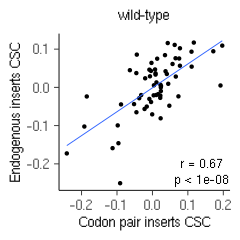

In [14]:
options(repr.plot.width = 2, repr.plot.height = 2)

pearson_r = cor(dicodon_endo_csc$dicodon_csc, dicodon_endo_csc$endo_csc, method=c('pearson'))
pearson_p = cor.test(dicodon_endo_csc$dicodon_csc, dicodon_endo_csc$endo_csc, method=c('pearson'))$p.value

dicodon_endo_csc %>%
    mutate(name = str_c(codon, " (", GENETIC_CODE[codon], ")")) %>%
    ggplot() +
    aes(x=dicodon_csc, y=endo_csc) +
    geom_point(size=0.2) +
    geom_smooth(method=lm, se=FALSE, linewidth=0.2) +
    annotate('text', x = 0.140, y = -0.20, label = str_c("r = ", round(pearson_r, 2)),  size=7/.pt) +
    annotate('text', x = 0.140, y = -0.24, label = "p < 1e-08", size=7/.pt) +
    theme +
    theme(
        plot.title = element_text(hjust = 0.5, size=8)
    ) + 
    labs(x='Codon pair inserts CSC', y='Endogenous inserts CSC', title='wild-type')

ggsave("../figures/endo_vs_dicodon_codon_analogous_csc.pdf", width=2, height=1.95, units='in', dpi=300)

## Plot CSCs of dicodon library vs endogenous fragments library in hel2-del


In [15]:
barcode_counts_e67 <- read_tsv("../../hel2_syh1_mrna_grna/tables/barcode_insert_counts.tsv.gz")

Rows: 673897 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): genotype, sample_type
dbl (3): barcode_num, insert_num, barcode_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [16]:
inserts_lfc_hel2 <- barcode_counts_e67 %>%
    filter(genotype == 'hel2') %>%
    group_by(genotype, sample_type, insert_num) %>%
    summarize(count = sum(barcode_count), n_barcodes = n(), .groups='drop') %>%
    filter(n_barcodes >= barcodes_cutoff) %>%
    filter(count >= insert_reads_cutoff) %>%
    pivot_wider(names_from = c(sample_type), values_from = c(count, n_barcodes)) %>%
    mutate(lfc = log2(count_mrna) - log2(count_gdna)) %>%
    drop_na(lfc) %>%
    left_join(insert_annotations_codon_freq, by='insert_num') %>%
    mutate(type = ifelse(insert_num >=4095, 'endo', 'dicodon')) %>%
    group_by(type) %>%
    mutate(lfc_med = lfc - median(lfc)) %>%
    select(-insert) %>%
    ungroup()

head(inserts_lfc_hel2)

genotype,insert_num,count_gdna,count_mrna,n_barcodes_gdna,n_barcodes_mrna,lfc,AAA,AAC,AAG,⋯,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,type,lfc_med
<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
hel2,1,7141,8225,27,31,0.20388956,0.5,0.5,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,0.1562122602
hel2,2,7567,12250,22,24,0.69498840,0.5,0.0,0.5,⋯,0,0,0,0,0,0,0,0,dicodon,0.6473110986
hel2,4,8960,9259,25,25,0.04735765,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.0003196462
hel2,5,25440,39600,62,59,0.63840176,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,0.5907244593
hel2,6,21431,19452,43,40,-0.13978067,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.1874579734
hel2,7,13769,11807,14,14,-0.22178134,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.2694586433


In [17]:
endo_insert_lfc <- inserts_lfc_hel2 %>%
    filter(insert_num > 4095)
dicodon_insert_lfc <- inserts_lfc_hel2 %>%
    filter(insert_num <= 4095)

In [18]:
endo_csc <- lapply(endo_insert_lfc[8:71], function(x) {
    cor(x, endo_insert_lfc$lfc_med, method='pearson')
}) %>%
    enframe() %>%
    rename(codon = name, corr_freq_lfc=value) %>%
    mutate(corr_freq_lfc = as.numeric(corr_freq_lfc))

Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”
Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”
Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”


In [19]:
dicodon_csc <- lapply(dicodon_insert_lfc[8:71], function(x) {
    cor(x, dicodon_insert_lfc$lfc_med, method='pearson')
}) %>%
    enframe() %>%
    rename(codon = name, corr_freq_lfc=value) %>%
    mutate(corr_freq_lfc = as.numeric(corr_freq_lfc))

In [20]:
dicodon_endo_csc <- dicodon_csc %>%
    rename(dicodon_csc = corr_freq_lfc) %>%
    inner_join(endo_csc, by='codon') %>%
    rename(endo_csc = corr_freq_lfc) %>%
    drop_na()

In [21]:
hel2_endo_dicodon_csc <- dicodon_endo_csc %>%
    mutate(genotype = 'hel2')

`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


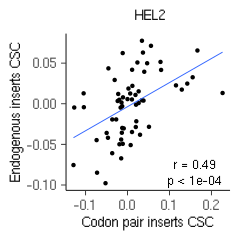

In [22]:
options(repr.plot.width = 2, repr.plot.height = 2)

pearson_r = cor(dicodon_endo_csc$dicodon_csc, dicodon_endo_csc$endo_csc, method=c('pearson'))
pearson_p = cor.test(dicodon_endo_csc$dicodon_csc, dicodon_endo_csc$endo_csc, method=c('pearson'))$p.value

dicodon_endo_csc %>%
    mutate(name = str_c(codon, " (", GENETIC_CODE[codon], ")")) %>%
    ggplot() +
    aes(x=dicodon_csc, y=endo_csc) +
    geom_point(size=0.2) +
    geom_smooth(method=lm, se=FALSE, linewidth=0.2) +
    annotate('text', x = 0.16, y = -0.075, label = str_c("r = ", round(pearson_r, 2)),  size=7/.pt) +
    annotate('text', x = 0.16, y = -0.095, label = "p < 1e-04", size=7/.pt) +
    theme +
    theme(
        plot.title = element_text(hjust = 0.5, size=8)
        ) + 
    labs(x='Codon pair inserts CSC', y='Endogenous inserts CSC', title=' hel2')

ggsave("../figures/hel2_endo_vs_dicodon_codon_analogous_csc.pdf", width=2, height=1.95, units='in', dpi=300)

## Plot CSC dicodon vs endogenous for Syh1

In [23]:
inserts_lfc_syh1 <- barcode_counts_e67 %>%
    filter(genotype == 'syh1') %>%
    group_by(genotype, sample_type, insert_num) %>%
    summarize(count = sum(barcode_count), n_barcodes = n(), .groups='drop') %>%
    filter(n_barcodes >= barcodes_cutoff) %>%
    filter(count >= insert_reads_cutoff) %>%
    pivot_wider(names_from = c(sample_type), values_from = c(count, n_barcodes)) %>%
    mutate(lfc = log2(count_mrna) - log2(count_gdna)) %>%
    drop_na(lfc) %>%
    left_join(insert_annotations_codon_freq, by='insert_num') %>%
    mutate(type = ifelse(insert_num >=4095, 'endo', 'dicodon')) %>%
    group_by(type) %>%
    mutate(lfc_med = lfc - median(lfc)) %>%
    select(-insert) %>%
    ungroup()

head(inserts_lfc_syh1)

genotype,insert_num,count_gdna,count_mrna,n_barcodes_gdna,n_barcodes_mrna,lfc,AAA,AAC,AAG,⋯,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,type,lfc_med
<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
syh1,1,3095,10708,28,28,1.790678,0.5,0.5,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,0.1265082
syh1,2,2350,6921,28,29,1.558320,0.5,0.0,0.5,⋯,0,0,0,0,0,0,0,0,dicodon,-0.1058498
syh1,4,3325,11318,24,26,1.767193,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,0.1030233
syh1,5,5273,20131,60,62,1.932723,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,0.2685534
syh1,6,4645,11636,44,51,1.324845,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.3393248
syh1,7,1653,4837,15,16,1.549026,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.1151437


In [24]:
endo_insert_lfc <- inserts_lfc_syh1 %>%
    filter(insert_num > 4095)
dicodon_insert_lfc <- inserts_lfc_syh1 %>%
    filter(insert_num <= 4095)

In [25]:
endo_csc <- lapply(endo_insert_lfc[8:71], function(x) {
    cor(x, endo_insert_lfc$lfc_med, method='pearson')
}) %>%
    enframe() %>%
    rename(codon = name, corr_freq_lfc=value) %>%
    mutate(corr_freq_lfc = as.numeric(corr_freq_lfc))

Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”
Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”
Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”


In [26]:
dicodon_csc <- lapply(dicodon_insert_lfc[8:71], function(x) {
    cor(x, dicodon_insert_lfc$lfc_med, method='pearson')
}) %>%
    enframe() %>%
    rename(codon = name, corr_freq_lfc=value) %>%
    mutate(corr_freq_lfc = as.numeric(corr_freq_lfc))

In [27]:
dicodon_endo_csc <- dicodon_csc %>%
    rename(dicodon_csc = corr_freq_lfc) %>%
    inner_join(endo_csc, by='codon') %>%
    rename(endo_csc = corr_freq_lfc) %>%
    drop_na()

`geom_smooth()` using formula = 'y ~ x'


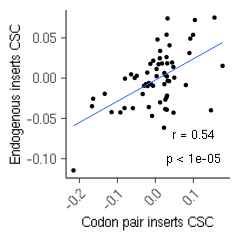

In [28]:
options(repr.plot.width = 2, repr.plot.height = 2)

pearson_r = cor(dicodon_endo_csc$dicodon_csc, dicodon_endo_csc$endo_csc, method=c('pearson'))
pearson_p = cor.test(dicodon_endo_csc$dicodon_csc, dicodon_endo_csc$endo_csc, method=c('pearson'))$p.value

dicodon_endo_csc %>%
    mutate(name = str_c(codon, " (", GENETIC_CODE[codon], ")")) %>%
    ggplot() +
    aes(x=dicodon_csc, y=endo_csc) +
    geom_point(size=0.2) +
    geom_smooth(method=lm, se=FALSE, linewidth=0.2) +
    annotate('text', x = 0.1, y = -0.07, label = str_c("r = ", round(pearson_r, 2)),  size=7/.pt) +
    annotate('text', x = 0.1, y = -0.1, label = "p < 1e-05", size=7/.pt) +
    theme +
    theme(axis.text.x=element_text(angle=45, hjust=1,vjust=1)) + 
    labs(x='Codon pair inserts CSC', y='Endogenous inserts CSC')

# ggsave("../figures/syh1_endo_vs_dicodon_codon_analogous_csc.pdf", width=1.95, height=1.7, units='in', dpi=300)

## Plot endogenous motifs library

In [29]:
insert_annotations <- read_csv("../../endo_motifs_linkage/annotations/insert_annotations.csv", show_col_types = F) %>%
    mutate(motif = as.character(translate(DNAStringSet(insert_seq), no.init.codon=TRUE)))

In [30]:
barcode_counts <- list.files("../data/linked_barcode_counts", full.names = T, pattern = ".csv$") %>%
  as_tibble_col("file") %>%
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>%
  mutate(data = map(file, . %>% read_csv(show_col_types = F))) %>%
  select(-file) %>%
  unnest(data) %>%
  mutate(insert_num = as.numeric(str_extract(insert_num, "\\d+")))

head(barcode_counts)

sample_name,barcode_count,insert_num,barcode_num,barcode,linkage_count
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
hel2_endo_dms_grna,7790,141,17580,TAGGATCTGCAGTTTGATCGTGTC,181
hel2_endo_dms_grna,7656,130,10137,GGGTATATGACTGTGGATGATGGT,290
hel2_endo_dms_grna,6821,142,10207,CGTTGTTGGCTCACGCACTAGCGC,289
hel2_endo_dms_grna,6686,54,25522,CAGTAGTGTTCCACTCGCTGCGTG,86
hel2_endo_dms_grna,6137,64,12465,TGTCAGTATGTTCGCAGTCTGCCG,252
hel2_endo_dms_grna,6063,16,1468,GCTTGCCGTGACGGTAACCCTTTG,564


In [31]:
library_size <- barcode_counts %>%
    group_by(sample_name) %>%
    summarize(total_reads = sum(barcode_count), .groups='drop')

In [32]:
barcode_counts %>%
    left_join(insert_annotations, by='insert_num') %>%
    group_by(sample_name, insert_num) %>%
    summarize(n_barc = n()) %>%
    group_by(sample_name) %>%
    summarize(med_n_barc = median(n_barc))

`summarise()` has grouped output by 'sample_name'. You can override using the
`.groups` argument.


sample_name,med_n_barc
<chr>,<dbl>
hel2_endo_dms_grna,12
hel2_endo_dms_mrna,12
wt_endo_dms_grna,15
wt_endo_dms_mrna,14


In [33]:
rpm_barcode_counts <- barcode_counts %>%
    filter(barcode_count >= barcode_reads_cutoff) %>%
    left_join(library_size, by='sample_name') %>%
    mutate(rpm = (barcode_count / total_reads)*1000000) %>%
    left_join(insert_annotations, by ='insert_num') %>%
    mutate(class = ifelse(is.na(class), id, class)) %>%
    separate(sample_name, c('genotype', 'x', 'y', 'sampletype')) %>%
    select(-x,-y, -barcode, -linkage_count, -type, -id, -gene, -loc, -wt_motif, -mutstart, -codon, -total_reads) %>%
    pivot_wider(names_from=sampletype, values_from=c(barcode_count, rpm)) %>%
    drop_na()

In [34]:
rpm_barcode_counts %>%
    group_by(genotype, insert_num) %>%
    summarize(n=n()) %>%
    mutate(med = median(n)) %>%
    dplyr::slice(1) %>%
    select(-insert_num, -n)

`summarise()` has grouped output by 'genotype'. You can override using the
`.groups` argument.


genotype,med
<chr>,<dbl>
hel2,10
wt,14


In [35]:
sdd1_wt <- rpm_barcode_counts %>%
    filter(insert_seq == 'GATTTCTTTTATGAAGATTATTTGATTTTCGATTGCAGAGCGAAACGACGAAAAAAATTGAAG') %>%
    mutate(class = 'endo_stall')

In [36]:
sdd1_ala <- rpm_barcode_counts %>%
    filter(class == 'sdd1') %>%
    left_join(insert_annotations, by =c('insert_num', 'motif', 'insert_seq')) %>%
    mutate(aa = ifelse(!(codon %in% c('TTG', 'CTG')), as.character(translate(DNAStringSet(codon))), 'L')) %>% 
    filter(aa == 'A') %>%
    filter(mutstart >= 43 & mutstart <=55) %>%
    mutate(class = 'endo_ala_cntrl') %>%
    select(genotype, insert_num, barcode_num, insert_seq, motif, class, barcode_count_grna, barcode_count_mrna, rpm_grna, rpm_mrna) %>%
    dplyr::rename(insert_num_actual = insert_num) %>%
    mutate(insert_num = 8000) 

In [37]:
endo_barcode_counts <- rpm_barcode_counts %>%
    filter(!class %in% c('fk8', 'sdd1')) %>%
    bind_rows(sdd1_wt) %>%
    bind_rows(sdd1_ala)

In [38]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$rpm_mrna)) - log2(sum(d$rpm_grna))
}

wt_insert_boot <- endo_barcode_counts %>%
    filter(genotype == 'wt') %>%
    group_by(insert_num) %>%
    nest() %>%
    mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
    select(-data) %>%
    mutate(lfc = map_dbl(lfc_boot, mean)) %>%
    mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
    select(-lfc_boot) %>%
    ungroup() %>%
    mutate(lfc_med = lfc - median(lfc)) %>%
    mutate(strain = 'wt')

hel2_insert_boot <- endo_barcode_counts %>%
    filter(genotype == 'hel2') %>%
    group_by(insert_num) %>%
    nest() %>%
    mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
    select(-data) %>%
    mutate(lfc = map_dbl(lfc_boot, mean)) %>%
    mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
    select(-lfc_boot) %>%
    ungroup() %>%
    mutate(lfc_med = lfc - median(lfc)) %>%
    mutate(strain = 'hel2')

insert_boot_rpm <- bind_rows(wt_insert_boot, hel2_insert_boot)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


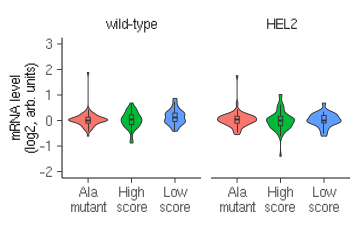

In [39]:
options(repr.plot.width=3, repr.plot.height=2)

insert_boot_rpm %>%
    left_join(insert_annotations, by='insert_num') %>%
    filter(!id %in% c('fk8', 'sdd1')) %>%
    filter(!class %in% c('dicodon_cntrl', 'human_ala_cntrl', 'human_stall')) %>%
    select(-loc, -wt_motif, -mutstart, -codon) %>%
    mutate(class = case_when(class == 'endo_ala_cntrl' ~ 'Ala\nmutant', class == 'endo_kr_cntrl' ~ 'K/R-dominant motifs', class == 'endo_nostall' ~ 'Low\nscore', class == 'endo_stall' ~ 'High\nscore')) %>%
    filter(class != 'K/R-dominant motifs') %>%
    mutate(Strain = ifelse(strain == 'wt', 'wild-type', ' hel2')) %>%
    ggplot() +
    aes(y=lfc_med, x=class, fill=class) +
    geom_violin(size=0.2) +
    facet_wrap(~factor(Strain, levels=c('wild-type', ' hel2')), ncol=2) +
    geom_boxplot(size=0.2, width=0.1, outlier.shape=NA) +
    scale_y_continuous(limits=c(-2,3)) +
    theme +
    theme(
        # axis.text.x=element_text(angle=45, hjust=1, vjust=1),
        legend.position='none',
        strip.text.x = element_text(size=8),
    )+
    labs(x='', y='mRNA level\n(log2, arb. units)')

ggsave("../figures/fig5_endo_group_summary.pdf", width=3, height=1.6)

## Plot top candidates against each other

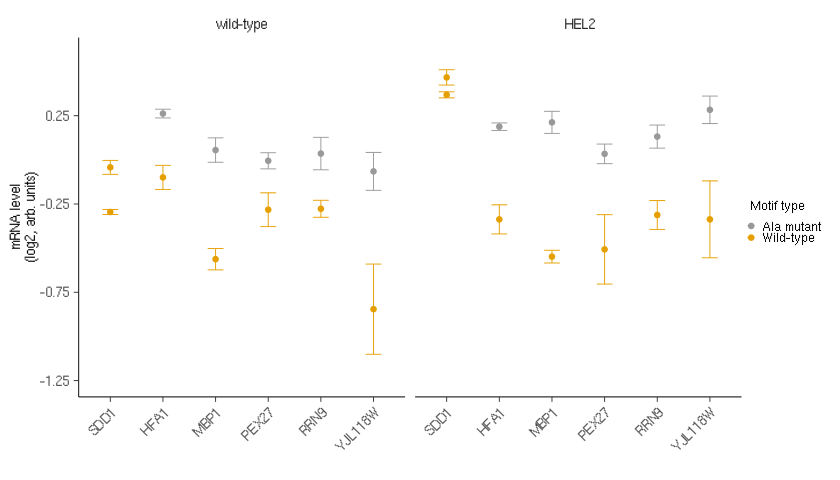

In [40]:
options(repr.plot.width=7, repr.plot.height=4)

candidates <- c('YJL118W', 'YDL056W', 'YMR207C', 'YMR270C', 'YOR193W', 'YJL118W', 'SDD1')
genenames <- c('SDD1', 'HFA1', 'MBP1', 'PEX27', 'RRN9', 'YJL118W')

insert_boot_rpm %>%
    left_join(insert_annotations, by='insert_num') %>%
    mutate(id = ifelse(insert_num == 852, 'SDD1', id)) %>%
    mutate(id = ifelse(is.na(insert_seq), 'SDD1', id)) %>%
    mutate(class = ifelse(id == 'SDD1', 'endo_ala_cntrl', class)) %>%
    filter(!id %in% c('fk8')) %>%
    select(-loc, -wt_motif, -mutstart, -codon) %>%
    mutate(class = ifelse(id == 'SDD1', 'endo_stall', class)) %>%
    mutate(id = ifelse((class == 'endo_ala_cntrl') & (id == 'SDD1'), 'SDD1', id)) %>%
    filter(id %in% candidates) %>%
    mutate(gene2 = ifelse(is.na(gene), id, gene)) %>%
    mutate(gene2 = factor(gene2, levels=genenames)) %>%
    mutate(class = case_when(class == 'endo_ala_cntrl' ~ 'Ala mutant', class == 'endo_stall' ~ 'Wild-type')) %>%
    mutate(Strain = ifelse(strain == 'wt', 'wild-type', ' hel2')) %>%
    ggplot() +
    aes(x=gene2, y=lfc_med, ymin=lfc_med-lfc_sd, ymax=lfc_med+lfc_sd, color=class) +
    facet_wrap(~factor(Strain, levels=c('wild-type', ' hel2')), ncol=2) +
    geom_point(size=0.8) +
    geom_errorbar(linewidth=0.2, width=0.3) +
    theme + 
    scale_y_continuous(breaks=seq(-1.25, 0.5, 0.5), limits=c(-1.25, 0.6)) +
    theme(
        axis.text.x = element_text(angle = 45, hjust=1, vjust=1),
        strip.text.x = element_text(size=8),
        legend.text=element_text(size=7),
        legend.title=element_text(size=7),
        legend.key.height = unit(2, 'mm'),
        legend.key.width = unit(2, 'mm'),
        legend.box.margin=margin(-10,0,-15,-15),
        ) +
    labs(x='', y='mRNA level\n(log2, arb. units)', color='Motif type')

ggsave("../figures/fig5_endo_candidates.pdf", width=3.7, height=1.8)

In [41]:
options(matrix.matr.rows=10)
insert_boot_rpm %>%
    left_join(insert_annotations, by='insert_num') %>%
    mutate(id = ifelse(insert_num == 852, 'SDD1', id)) %>%
    mutate(id = ifelse(is.na(insert_seq), 'SDD1', id)) %>%
    mutate(class = ifelse(id == 'SDD1', 'endo_ala_cntrl', class)) %>%
    filter(!id %in% c('fk8')) %>%
    select(-loc, -wt_motif, -mutstart, -codon) %>%
    mutate(class = ifelse(id == 'SDD1', 'endo_stall', class)) %>%
    mutate(id = ifelse((class == 'endo_ala_cntrl') & (id == 'SDD1'), 'SDD1', id)) %>%
    filter(id %in% candidates) %>%
    mutate(gene2 = ifelse(is.na(gene), id, gene)) %>%
    mutate(gene2 = factor(gene2, levels=genenames)) %>%
    mutate(class = case_when(class == 'endo_ala_cntrl' ~ 'Ala mutant', class == 'endo_stall' ~ 'Wild-type')) %>%
    mutate(Strain = ifelse(strain == 'wt', 'wild-type', ' hel2')) %>%
    filter(Strain == 'wild-type') %>%
    filter(class != 'Ala mutant')

insert_num,lfc,lfc_sd,lfc_med,strain,insert_seq,motif,type,id,gene,class,gene2,Strain
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>
104,-0.08958106,0.04812173,-0.27708519,wt,AAATCATTAGAGCTATATAACGATATCCCAGAAAAGTATAAAAAGAGAAAATTCAGACTGCCC,KSLELYNDIPEKYKKRKFRLP,posbulky,YMR270C,RRN9,Wild-type,RRN9,wild-type
103,0.08827604,0.06825597,-0.09922809,wt,CTAGTTAAAGGAGTAATCCGAAATGAGTTGGAATGGAAAAAGTCACGCAGATTTTTATATTGG,LVKGVIRNELEWKKSRRFLYW,posbulky,YMR207C,HFA1,Wild-type,HFA1,wild-type
73,-0.37498875,0.06054707,-0.56249288,wt,GAAATTTTATCTCGTCTACAAGAACAAAATACTAAGAAATTGAGAAAAAGGCTCATACGATAC,EILSRLQEQNTKKLRKRLIRY,posbulky,YDL056W,MBP1,Wild-type,MBP1,wild-type
93,-0.65815157,0.25536372,-0.84565569,wt,CCCATTATACAACACACACACGTTAAGAGACGCAAACGGCCTCGTCTGAGGATCGTAGCCATC,PIIQHTHVKRRKRPRLRIVAI,posbulky,YJL118W,NA,Wild-type,YJL118W,wild-type
105,-0.09488378,0.09558126,-0.28238791,wt,TATAAAATTATCAAAAGATTTCGCTGGTTGAGAGAAATGAAAAAACTACATTATAAAGATCAA,YKIIKRFRWLREMKKLHYKDQ,FK,YOR193W,PEX27,Wild-type,PEX27,wild-type
852,-0.10787644,0.01385836,-0.29538057,wt,GATTTCTTTTATGAAGATTATTTGATTTTCGATTGCAGAGCGAAACGACGAAAAAAATTGAAG,DFFYEDYLIFDCRAKRRKKLK,NA,SDD1,NA,Wild-type,SDD1,wild-type
8000,0.14503512,0.03943562,-0.04246901,wt,NA,NA,NA,SDD1,NA,Wild-type,SDD1,wild-type


## Plot distributions

In [42]:
insert_boot_rpm %>%
    left_join(insert_annotations, by='insert_num') %>%
    filter(!id %in% c('fk8', 'SDD1')) %>%
    filter(!class %in% c('dicodon_cntrl', 'human_ala_cntrl', 'human_stall')) %>%
    group_by(class) %>%
    summarize(n())

class,n()
<chr>,<int>
endo_ala_cntrl,132
endo_kr_cntrl,22
endo_nostall,52
endo_stall,116
NA,4


In [43]:
endo_motifs <- insert_boot_rpm %>%
    filter(strain == 'wt') %>%
    mutate(type = 'endo_motifs') %>%
    select(type, lfc_med)

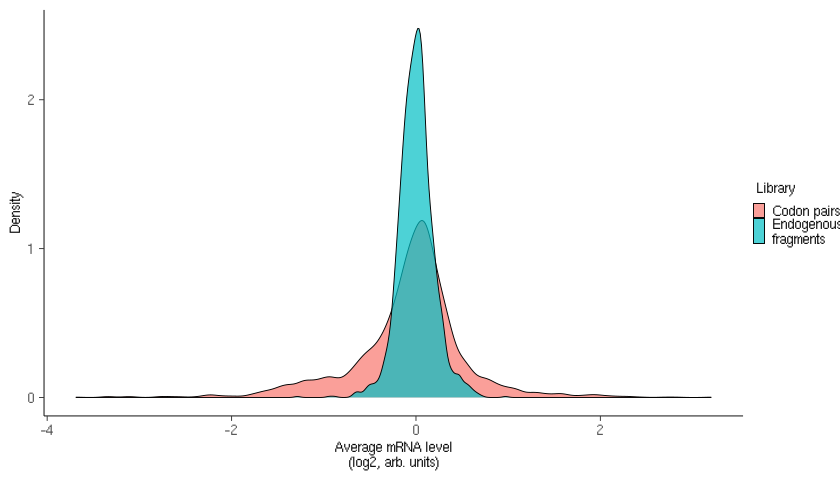

In [44]:
inserts_lfc %>%
    select(type, lfc_med) %>%
    # bind_rows(endo_motifs) %>%
    mutate(type = case_when(type == 'dicodon' ~ 'Codon pairs', type == 'endo' ~ 'Endogenous\nfragments', type == 'endo_motifs' ~ 'Endogenous motifs')) %>%
    ggplot() +
    aes(x=lfc_med, fill=type) +
    geom_density(alpha=0.7, linewidth=0.2) +
    scale_y_continuous(breaks=seq(0,3,1)) +
    theme +
    theme(legend.box.margin=margin(-12,-12,-12,-12),) +
    guides(fill = guide_legend(
                 keywidth=0.1,
                 keyheight=0.125,
                 default.unit="inch",
                 linewidth=0.2)) +
    labs(y='Density', x='Average mRNA level\n(log2, arb. units)', fill='Library')

ggsave("../figures/dist_dicodon_vs_endo_fragments.pdf", width=3, height=1.7)